In [ ]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import scipy.stats as stats
import matplotlib.pyplot as plt

from funs_load_X_and_Y import load_X_Y

In [14]:
# dataset_name: "coqa", "triviaqa", "wmt", "mmlu"
# model_type: "llama_2_7b", "gemma_7b", "llama_3_8b"

dataset_name = "triviaqa"
model_type = ["llama_2_7b", "llama_3_8b", "gemma_7b"]
with_entropy = True

X_mids, X_lasts, ys = [], [], []

for m in model_type:
    data_train_list,data_test_list,name_list,y_train,y_test,SU_test,ask4conf_test = load_X_Y(dataset_name, m, with_entropy=with_entropy)
    name2idx = {n: i for i, n in enumerate(name_list)}
    mididx = name2idx['answerm last-token mid layer']
    lastidx = name2idx['answerm last-token last layer']

    X_mid = data_train_list[mididx]
    X_last = data_train_list[lastidx]
    y = y_train

    X_mid = X_mid.cpu().detach().numpy()
    X_last = X_last.cpu().detach().numpy()
    y = np.array(y)

    # truncate
    if m.startswith("llama"):
        X_mid = X_mid[:, :4096]
        X_last = X_last[:, :4096]
    elif m.startswith("gemma"):
        X_mid = X_mid[:, :3072]
        X_last = X_last[:, :3072]
        
    print(m, X_mid.shape, X_last.shape, y.shape)
    X_mids.append(X_mid)
    X_lasts.append(X_last)
    ys.append(y)

load triviaqa__train 2000
load triviaqa__train 18000
llama_2_7b (18000, 4096) (18000, 4096) (18000,)
load triviaqa__train 2000
load triviaqa__train 18000
llama_3_8b (18000, 4096) (18000, 4096) (18000,)
load triviaqa__train 2000
load triviaqa__train 18000
gemma_7b (18000, 3072) (18000, 3072) (18000,)


In [16]:
mid_spearmans = []
last_spearmans = []
for Xm, Xl in zip(X_mids, X_lasts):
    mid_spearmans.append([stats.spearmanr(Xm[:, i], y)[0] for i in range(Xm.shape[1])])
    last_spearmans.append([stats.spearmanr(Xl[:, i], y)[0] for i in range(Xl.shape[1])])

In [15]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

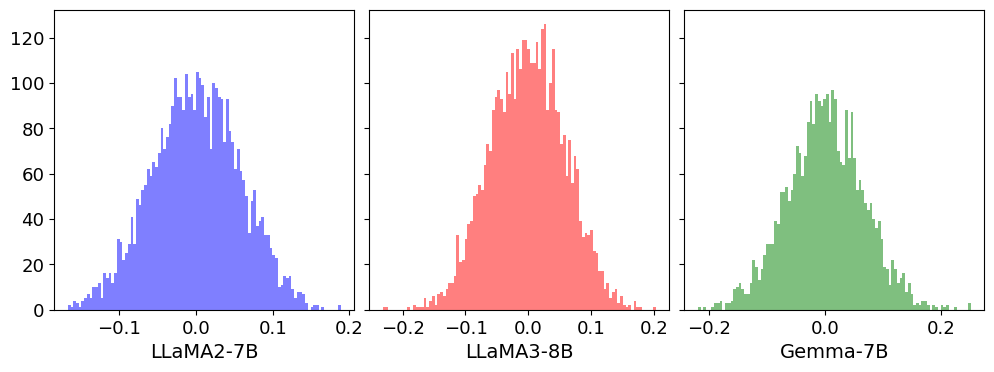

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4),sharey=True)
handles,labels = [],[]

axs[0].set_box_aspect(1)
hist1 = axs[0].hist(mid_spearmans[0], bins=100, alpha=0.5, color="blue")
axs[0].set_xlabel(f"LLaMA2-7B",fontsize=14)

axs[1].set_box_aspect(1)
hist2 = axs[1].hist(mid_spearmans[1], bins=100, alpha=0.5, color="red")
axs[1].set_xlabel(f"LLaMA3-8B",fontsize=14)

axs[2].set_box_aspect(1)
hist3 = axs[2].hist(mid_spearmans[2], bins=100, alpha=0.5, color="green")
axs[2].set_xlabel(f"Gemma-7B",fontsize=14)

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(top=0.98)
plt.show()

fig_name = 'figs/plot_spearman_corr_hist_midlayer.pdf'
fig.savefig(fig_name, bbox_inches='tight')

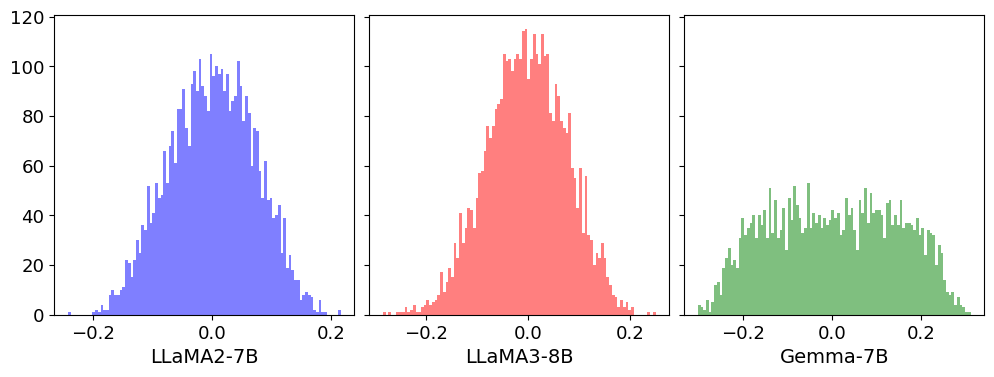

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4),sharey=True)
handles,labels = [],[]

axs[0].set_box_aspect(1)
hist1 = axs[0].hist(last_spearmans[0], bins=100, alpha=0.5, color="blue")
axs[0].set_xlabel(f"LLaMA2-7B",fontsize=14)

axs[1].set_box_aspect(1)
hist2 = axs[1].hist(last_spearmans[1], bins=100, alpha=0.5, color="red")
axs[1].set_xlabel(f"LLaMA3-8B",fontsize=14)

axs[2].set_box_aspect(1)
hist3 = axs[2].hist(last_spearmans[2], bins=100, alpha=0.5, color="green")
axs[2].set_xlabel(f"Gemma-7B",fontsize=14)

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(top=0.98)
plt.show()

fig_name = 'figs/plot_spearman_corr_hist_lastlayer.pdf'
fig.savefig(fig_name, bbox_inches='tight')

In [22]:
# ! will not use this cell

y_bin = (y > 0.3).astype(int)
y_bin = pd.DataFrame(y_bin)
y_pos = y_bin.where(y_bin == 1).dropna().index.tolist()
y_neg = y_bin.where(y_bin == 0).dropna().index.tolist()

from tqdm.auto import tqdm

t_test_mids, t_test_lasts = [], []

for Xm, Xl in zip(X_mids, X_lasts):
    t_test_mid, t_test_last = [], []
    Xm = pd.DataFrame(Xm)
    Xl = pd.DataFrame(Xl)
    for i in tqdm(range(Xm.shape[1])):
        t_test_mid.append((i, abs(Xm.iloc[y_pos, i].mean() - Xm.iloc[y_neg, i].mean())))
        t_test_last.append((i, abs(Xl.iloc[y_pos, i].mean() - Xl.iloc[y_neg, i].mean())))
    t_test_mids.append(t_test_mid)
    t_test_lasts.append(t_test_last)
    
mid_diff_idxs, last_diff_idxs = [], []
for tt_mid, tt_last in zip(t_test_mids, t_test_lasts):
    mid_diff = pd.DataFrame([_[1] for _ in tt_mid], index=[_[0] for _ in tt_mid])
    last_diff = pd.DataFrame([_[1] for _ in tt_last], index=[_[0] for _ in tt_last])
    mid_q95 = mid_diff.quantile(0.99)
    last_q95 = last_diff.quantile(0.99)
    mid_diff_idxs.append(mid_diff[mid_diff > mid_q95].dropna().index.tolist())
    last_diff_idxs.append(last_diff[last_diff > last_q95].dropna().index.tolist())

  3%|▎         | 141/4096 [00:00<00:19, 205.76it/s]/home/linyuliu/.conda/envs/uncertainty_quantification/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
 19%|█▉        | 777/4096 [00:03<00:15, 211.54it/s]/tmp/ipykernel_859369/1813503302.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  t_test_last.append((i, abs(Xl.iloc[y_pos, i].mean() - Xl.iloc[y_neg, i].mean())))
100%|██████████| 3072/3072 [00:14<00:00, 210.61it/s]


In [61]:
mid_selected_neurons = [np.argsort(np.abs(ms))[::-1][:4] for ms in mid_spearmans]
last_selected_neurons = [np.argsort(np.abs(ls))[::-1][:4] for ls in last_spearmans]

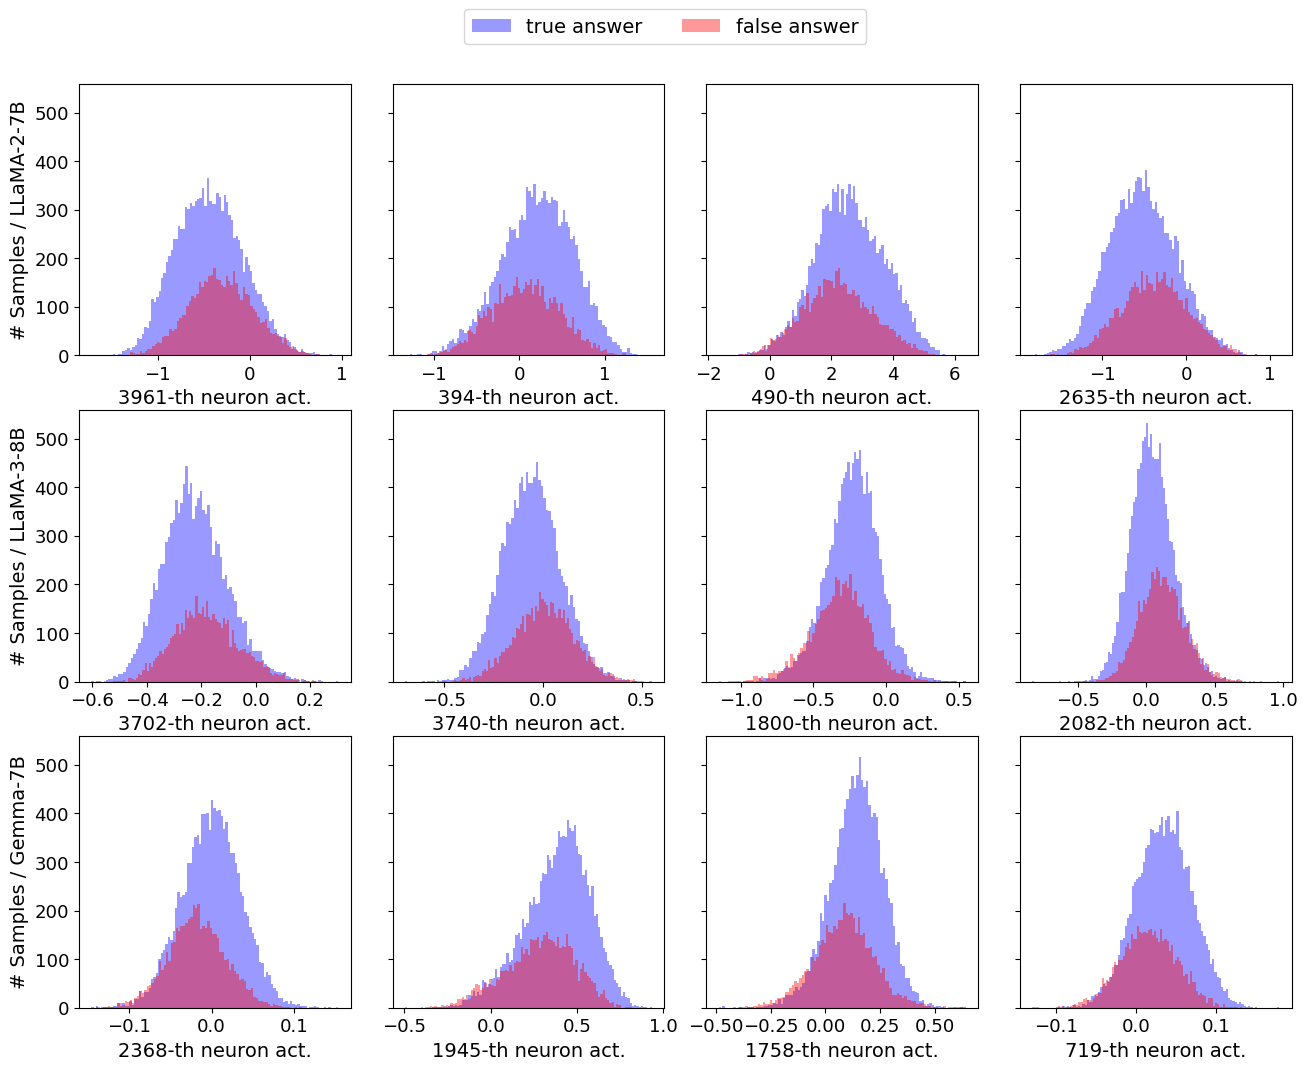

In [64]:
import random

N_MODEL = 3
N_SAMPLE = 4

idx2name = {0: "LLaMA-2-7B", 1: "LLaMA-3-8B", 2: "Gemma-7B"}

fig, axs = plt.subplots(N_MODEL, N_SAMPLE, figsize=(N_SAMPLE * 4, N_MODEL * 4),sharey=True)
handles,labels = [], []
all_hists_pos = []
all_hists_neg = []

for H in range(N_MODEL):
    sampled_neurons = random.sample(mid_selected_neurons[H].tolist(), N_SAMPLE)
    all_hists_pos.append([])
    all_hists_neg.append([])
    for W in range(N_SAMPLE):
        axs[H][W].set_box_aspect(1)
        hist_pos = axs[H][W].hist(pd.DataFrame(X_mids[H]).iloc[y_pos, sampled_neurons[W]], bins=100, alpha=0.4, color="blue", label="true answer")
        hist_neg = axs[H][W].hist(pd.DataFrame(X_mids[H]).iloc[y_neg, sampled_neurons[W]], bins=100, alpha=0.4, color="red", label="false answer")
        all_hists_pos[H].append(hist_pos)
        all_hists_neg[H].append(hist_neg)
        axs[H][W].set_xlabel(f"{sampled_neurons[W]}-th neuron act.", fontsize=14)
        if W == 0:
            axs[H][W].set_ylabel(f"# Samples / {idx2name[H]}", fontsize=14)
        if W == 0 and H == 0:
            handles.extend([hist_pos[2][0], hist_neg[2][0]])
            labels.extend(["true answer","false answer"])
            
plt.subplots_adjust(wspace=0.05)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0.95), ncol=2,fontsize=14)    

fig_name = 'figs/plot_answerm_act_midlayer.pdf'
fig.savefig(fig_name, bbox_inches='tight')

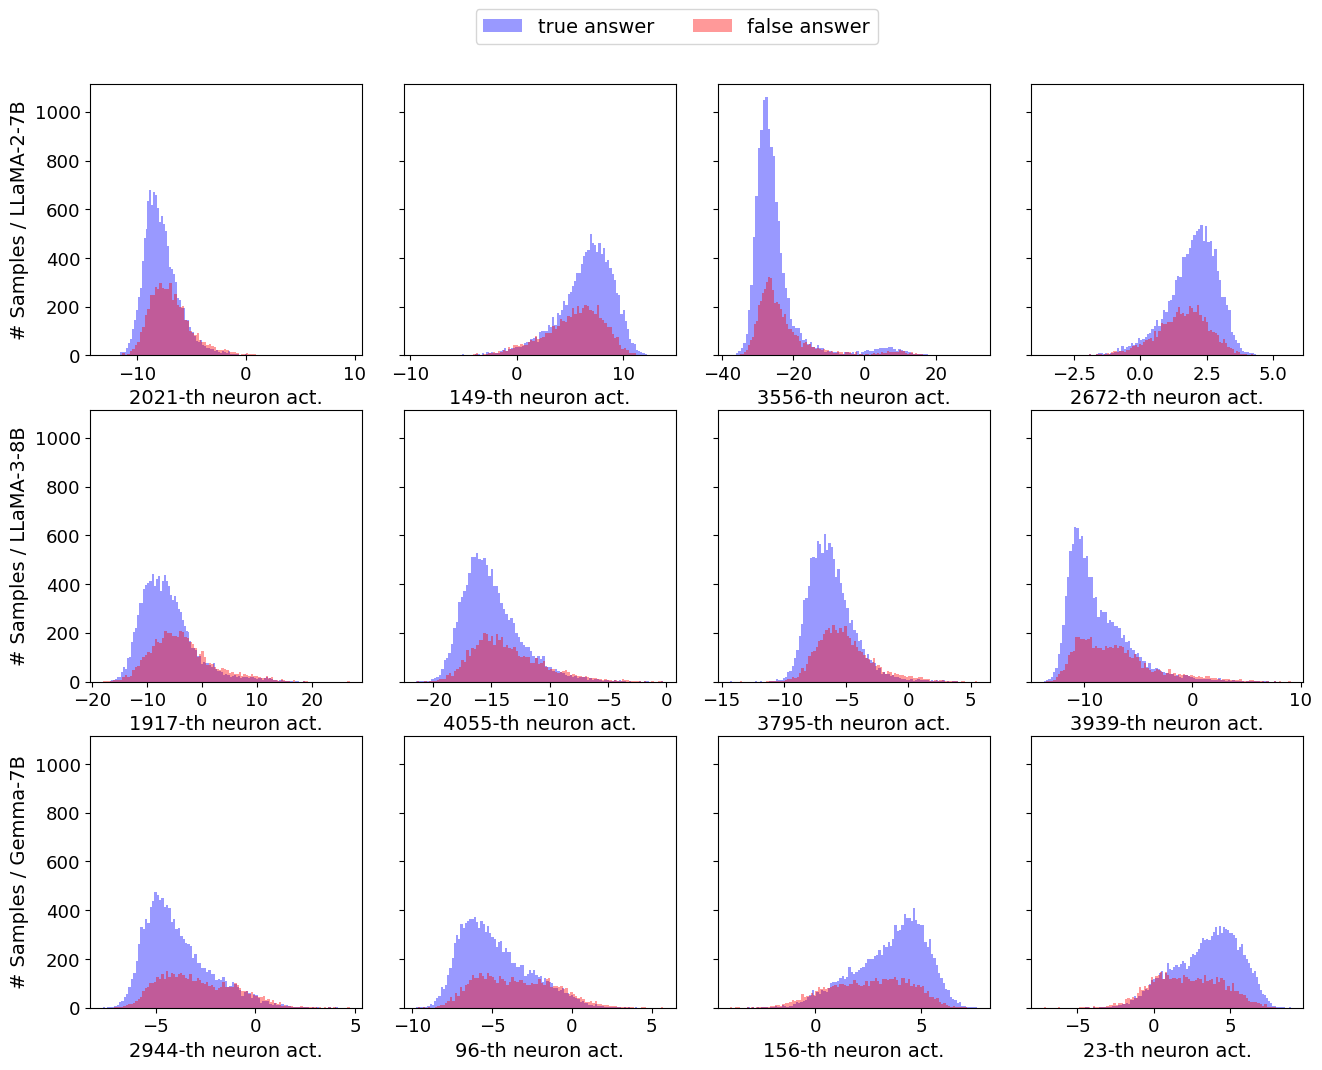

In [65]:
N_MODEL = 3
N_SAMPLE = 4

idx2name = {0: "LLaMA-2-7B", 1: "LLaMA-3-8B", 2: "Gemma-7B"}

fig, axs = plt.subplots(N_MODEL, N_SAMPLE, figsize=(N_SAMPLE * 4, N_MODEL * 4),sharey=True)
handles,labels = [], []
all_hists_pos = []
all_hists_neg = []

for H in range(N_MODEL):
    sampled_neurons = random.sample(last_selected_neurons[H].tolist(), N_SAMPLE)
    all_hists_pos.append([])
    all_hists_neg.append([])
    for W in range(N_SAMPLE):
        axs[H][W].set_box_aspect(1)
        hist_pos = axs[H][W].hist(pd.DataFrame(X_lasts[H]).iloc[y_pos, sampled_neurons[W]], bins=100, alpha=0.4, color="blue", label="true answer")
        hist_neg = axs[H][W].hist(pd.DataFrame(X_lasts[H]).iloc[y_neg, sampled_neurons[W]], bins=100, alpha=0.4, color="red", label="false answer")
        all_hists_pos[H].append(hist_pos)
        all_hists_neg[H].append(hist_neg)
        axs[H][W].set_xlabel(f"{sampled_neurons[W]}-th neuron act.", fontsize=14)
        if W == 0:
            axs[H][W].set_ylabel(f"# Samples / {idx2name[H]}", fontsize=14)
        if W == 0 and H == 0:
            handles.extend([hist_pos[2][0], hist_neg[2][0]])
            labels.extend(["true answer","false answer"])
            
plt.subplots_adjust(wspace=0.05)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0.95), ncol=2,fontsize=14)    

fig_name = 'figs/plot_answerm_act_lastlayer.pdf'
fig.savefig(fig_name, bbox_inches='tight')